In [ ]:
# import ds_utils
# import stan_utils
from scipy.stats import multivariate_normal, nakagami, gamma
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import KernelDensity

# Likelihood com distribuição de Nakagami

Como visto [aqui](https://www.sciencedirect.com/science/article/abs/pii/S0925231217304320), a distância euclidiana pode
ser modelada por uma distribuição de Nakagami. Assim, queremos usar a distribuição de Nakagami na função de likilihood.
Para isso precisamos encontrar os parâmetros da distribuição de Nakagami que permitam posicionar a distribuição com a
moda na distância estimada e escolher o parâmetro de dispersão, de forma semelhante ao que foi feito no item anterior.

## Explorando os parâmetros da distribuição de Nakagami

Também na [wikipedia](https://en.wikipedia.org/wiki/Nakagami_distribution) vemos que uma distribuição $Nakagami(m, \Omega)$ possui moda dada por $$moda(m, \Omega) = \frac{\sqrt{2}}{2}\sqrt{\frac{(2m-1)\Omega}{m}}$$

Nosso objetivo é posicionar a moda em $d$ mantendo livre o parâmetro de dispersão para que se possa variar a largura da distribuição (como fizemos para Gamma). Vamos resolver a equação $moda(m, \Omega) = d$
considerando $\Omega$ uma constante, pois ela será um hiperparâmetro do modelo.
Fazendo isso chegamos em $$m = \frac{\Omega}{2(\Omega - d^2)}$$

Essa expressão traz um problema em relação as restrições quanto ao valor de $m$.
Note que, como $\Omega > 0$ (também uma restrição da distribuição), sempre que
$\Omega < d^2$, teríamos $m < 0$. Essa questão não pode ser ignorada, pois estamos
falando sobre o parâmetro de dispersão ser menor que um número dado por uma distância
(que pode ser arbitrariamente grande) elevada ao quadrado.

Para garantir $\Omega > d^2$, iremos receber do usuário um parâmetro de dispersão
$\theta > 0$ e faremos $\Omega = d^2 + \theta$.
Note que essa configuração também garante $m \geq \frac{1}{2}$.

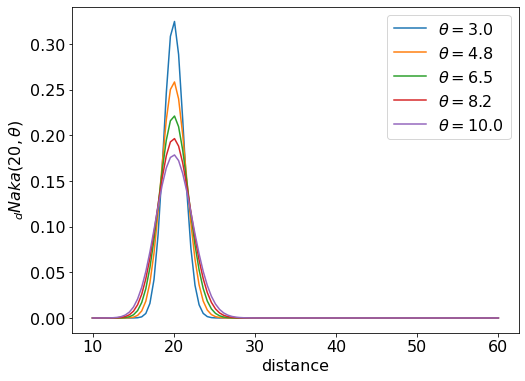

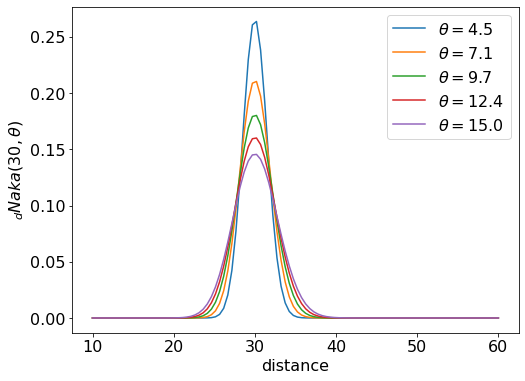

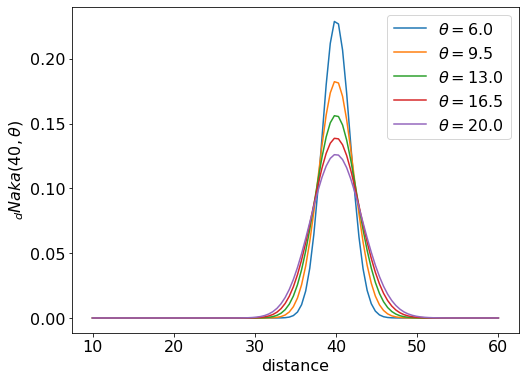

In [ ]:
plt.rcParams.update({'font.size': 16})

x = np.linspace(10, 60, 100)
result = {r'$\delta$':[], r'$\theta$':[], 'variance':[]}
for radius in [20, 30, 40]:
    plt.figure(figsize=[8, 6])
    # plt.title('radius = %d'%(radius))
    plt.xlabel('distance')
    plt.ylabel(r'$_dNaka(%d, \theta)$'%radius)
    for theta in np.linspace(.15, .5, 5)*radius:
        omega = radius**2 + theta;
        m = omega/(2*(omega-radius**2))
        naka = nakagami(m, scale=np.sqrt(omega))
        p = naka.pdf(x)
        plt.plot(x, p)        
        result[r'$\delta$'].append(radius)
        result[r'$\theta$'].append(theta)
        result['variance'].append(naka.var())
    plt.legend([r'$\theta = %1.1f$' % ti for ti in np.linspace(.15, .5, 5)*radius])

# Variância da likelihood

Na figura abaixo vemos a relação entre a variância da função de likelihood em
relação ao parâmetro de dispersão usado. Aqui fica claro que existe uma relação linear e
que a variância é aproximadamente a metade do valor de theta.

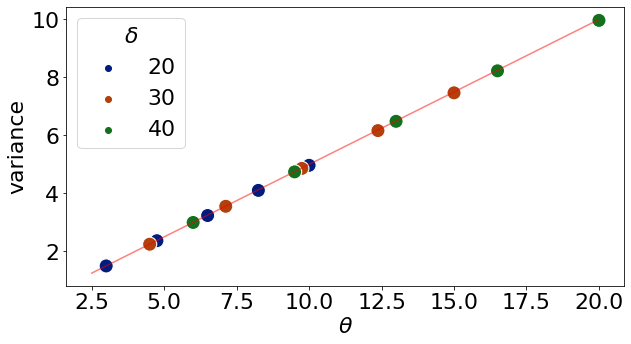

In [ ]:
plt.rcParams.update({'font.size': 22})
f, ax = plt.subplots(1,1, figsize=[10, 20])
ax.set_aspect('equal')
sns.scatterplot(x=r'$\theta$', y='variance', hue=r'$\delta$', data=result, ax=ax, s=200, palette='dark')

# ax.set_ylabel(r'$var[p(\delta_{kn}||t - r_k|, \theta)]$')
ax.set_xlabel(r'$\theta$')
ax.plot([2.5, 20], [1.25, 10], 'r-', alpha=0.5, label=r'$var = 2\theta_k$')


# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)#, title=r'$|t - r_k|$')
# print(result['var'])
# print(result['theta'])
# print([a - 2*b for a,b in zip(result['theta'], result['var'])])

# Stan model com Nakagami Likelihood

Vamos analisar o comportamento do modelo com função de likelihood
de Nakagamu no cenário mais difícil ($K = 3$, $raio = 40$) e comparar com
os resultados obtidos nos demais métodos.

Obs.: nesse experimento fizemos $\theta = \frac{d}{5}$, assim temos
a variância da função de likelihood igual a $10\%$ da distância.

In [ ]:
import multilateration as mlat


k = 3
radius = 40

result = pd.read_csv('./results/results_K_%d_RD_%d.csv'%(k, radius))
result = result[result['method'] != 'BMLAT']
sm = stan_utils.compile_model('mlat_nakagami_q0')

for noise_std in np.linspace(4, 10, 10):
  data = ds_utils.generate_dataset(k, radius, noise_std)
  q_star = data['q']
  data['theta'] = 0.2*radius

  data['q0'] = mlat.monte_carlo_sampler('LMLAT', data['R'], data['d'], noise_std).mean(axis=0)
  data['q_std'] = noise_std
  data['theta'] = 0.2 * radius


  for run in np.arange(10):
    fit = sm.sampling(data=data, iter=1000, chains=4, control=dict(max_treedepth=12, adapt_delta=.9))
    Q = params = fit.extract()['q']

    q_mean = Q.mean(axis=0)
    C = np.cov(Q.T)
    likelihood = multivariate_normal.pdf(q_star, q_mean, C)
    loglike = multivariate_normal.logpdf(q_star, q_mean, C)
    dist = distance.cdist(q_star, q_mean.reshape(1,-1))[0,0]
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(Q)

    res = {'noise_level': [noise_std],
          'likelihood': [likelihood],
          'loglikelihood': [loglike],
          'kde': [kde.score(q_star)],
          'distance':[dist],
          'method': ['BMLAT'],
          'run':[run]}
    result = result.append(pd.DataFrame(res))

    print('noise_std = %1.1f\trun = %d'%(noise_std, run))

Using cached StanModel
noise_std = 4.0	run = 0
noise_std = 4.0	run = 1
noise_std = 4.0	run = 2
noise_std = 4.0	run = 3
noise_std = 4.0	run = 4
noise_std = 4.0	run = 5
noise_std = 4.0	run = 6
noise_std = 4.0	run = 7
noise_std = 4.0	run = 8
noise_std = 4.0	run = 9
noise_std = 4.7	run = 0
noise_std = 4.7	run = 1
noise_std = 4.7	run = 2
noise_std = 4.7	run = 3
noise_std = 4.7	run = 4
noise_std = 4.7	run = 5
noise_std = 4.7	run = 6
noise_std = 4.7	run = 7
noise_std = 4.7	run = 8
noise_std = 4.7	run = 9
noise_std = 5.3	run = 0
noise_std = 5.3	run = 1
noise_std = 5.3	run = 2
noise_std = 5.3	run = 3
noise_std = 5.3	run = 4
noise_std = 5.3	run = 5
noise_std = 5.3	run = 6
noise_std = 5.3	run = 7
noise_std = 5.3	run = 8
noise_std = 5.3	run = 9
noise_std = 6.0	run = 0
noise_std = 6.0	run = 1
noise_std = 6.0	run = 2
noise_std = 6.0	run = 3
noise_std = 6.0	run = 4
noise_std = 6.0	run = 5
noise_std = 6.0	run = 6
noise_std = 6.0	run = 7
noise_std = 6.0	run = 8
noise_std = 6.0	run = 9
noise_std = 6.7	r

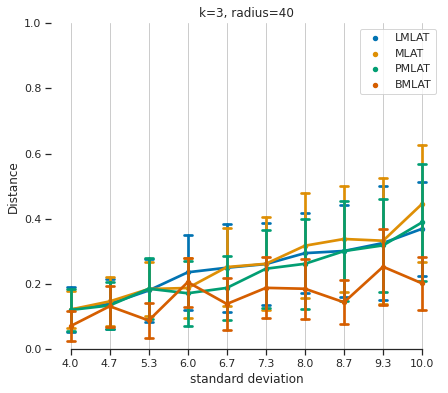

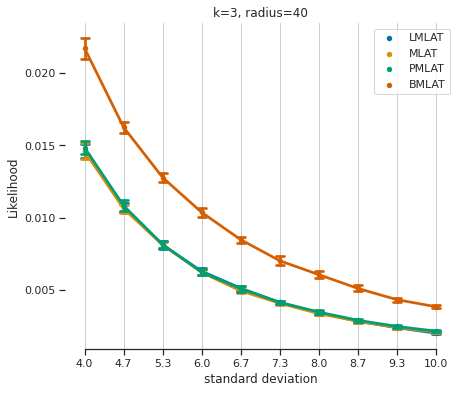

In [ ]:
result['noise_level'] = result['noise_level'].round(decimals=1)


sns.set_theme(style="ticks")
## Distance
f, ax = plt.subplots(figsize=(7, 6))

g = sns.pointplot(x="noise_level", y="distance", data=result, hue='method', ci='sd', markers='.', palette="colorblind", capsize=.2)

ax.xaxis.grid(True)
ax.set(ylabel="Distance", xlabel='standard deviation', title="k=%d, radius=%d"%(k, radius), ylim=[0, 1])
sns.despine(trim=True, left=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['LMLAT', 'MLAT', 'PMLAT', 'BMLAT'], title="")

## Likelihood
f, ax = plt.subplots(figsize=(7, 6))

g = sns.pointplot(x="noise_level", y="likelihood", data=result, hue='method', ci='sd', markers='.', palette="colorblind", capsize=.2)

ax.xaxis.grid(True)
ax.set(ylabel="Likelihood", xlabel='standard deviation', title="k=%d, radius=%d"%(k, radius))#, ylim=[0, 1])
sns.despine(trim=True, left=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['LMLAT', 'MLAT', 'PMLAT', 'BMLAT'], title="")